# Two Moons: Tackling Bimodal Posteriors

## Table of Contents
 * [Inference Network and Amortizer](#inference_network_and)
 * [Trainer](#trainer)
 * [Validation](#validation)
	 * [Global Calibration](#global_calibration)
	 * [Two Moons Posterior](#two_moons_posterior)
 * [Further Experimentation](#further_experimentation)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm

import keras

## REMOVE ON PRODUCTION
import sys
sys.path.append('../')

from bayesflow.experimental.networks import CouplingFlow
from bayesflow.experimental.amortizers import AmortizedPosterior
from bayesflow.experimental.datasets import OfflineDataset

from bayesflow import benchmarks

This example will demonstrate amortized estimation of a somewhat strange Bayesian model, whose posterior evaluated at the origin $x = (0, 0)$ of the "data" will resemble two crescent moons. The forward process is a noisy non-linear transformation on a 2D plane:

$$
\begin{align}
x_1 &= -|\theta_1 + \theta_2|/\sqrt{2} + r \cos(\alpha) + 0.25\\
x_2 &= (-\theta_1 + \theta_2)/\sqrt{2} + r\sin{\alpha}
\end{align}
$$

with $x = (x_1, x_2)$ playing the role of "observables", $\alpha \sim \text{Uniform}(-\pi/2, \pi/2)$, $r \sim \text{Normal}(0.1, 0.01)$, and a prior over the 2D parameter vector $\theta = (\theta_1, \theta_2)$:

$$
\begin{align}
\theta_1, \theta_2 \sim \text{Uniform}(-1, 1)
\end{align}
$$

This method is typically used for benchmarking simulation-based inference (SBI) methods (see https://arxiv.org/pdf/2101.04653) and any method for amortized Bayesian inference should be capable of recovering the two moons posterior *without* using a gazillion of simulations. Note, that this is a considerably harder task than modeling the common unconditional two moons data set used often in the context of normalizing flows.

The two moons generative model, along with all benchmarks from https://arxiv.org/pdf/2101.04653, exists as a standalone object in the `bayesflow.benchmarks` module. So let's import it using the `Benchmark` helper class.

In [ ]:
benchmark = benchmarks.Benchmark("two_moons", mode="posterior")

## Inference Network and Amortizer <a class="anchor" id="inference_network_and"></a>

In [ ]:
num_sims = 1000
batch_size = 32
offline_data = benchmark.generative_model(num_sims)

data = {
    "parameters": dict(theta=offline_data["prior_draws"]),
    "observables": dict(x=offline_data["sim_data"])
}
# TODO - remove batches_per_epoch from user interface
dataset = OfflineDataset(data, batch_size=batch_size, batches_per_epoch=num_sims//batch_size)

In [ ]:
epochs = 250

inference_net = CouplingFlow(depth=4, permutation="orthogonal")

amortizer = AmortizedPosterior(inference_net)

lr = keras.optimizers.schedules.CosineDecay(5e-4, decay_steps=int(epochs * dataset.batches_per_epoch))

optimizer = keras.optimizers.AdamW(lr, weight_decay=1e-3)

amortizer.compile(optimizer=optimizer)

In [ ]:
h = amortizer.fit(dataset, epochs=epochs)

## Validation <a class="anchor" id="validation"></a>
We can use simulation-based calibration(SBC) for free (due to amortization) checking of computational faithfulness.

1. Talts, S., Betancourt, M., Simpson, D., Vehtari, A., & Gelman, A. (2018). Validating Bayesian inference algorithms with simulation-based calibration. arXiv preprint arXiv:1804.06788.
2. Säilynoja, T., Bürkner, P. C., & Vehtari, A. (2022). Graphical test for discrete uniformity and its applications in goodness-of-fit evaluation and multiple sample comparison. Statistics and Computing, 32(2), 32.

In [ ]:
# TODO

### Two Moons Posterior <a class="anchor" id="two_moons_posterior"></a>

The two moons posterior at point $x = (0, 0)$ should resemble two crescent shapes. Below, we plot the corresponding posterior samples and posterior density. These results suggest that our spline flow setup can approximate the expected analytical posterior fairly well.

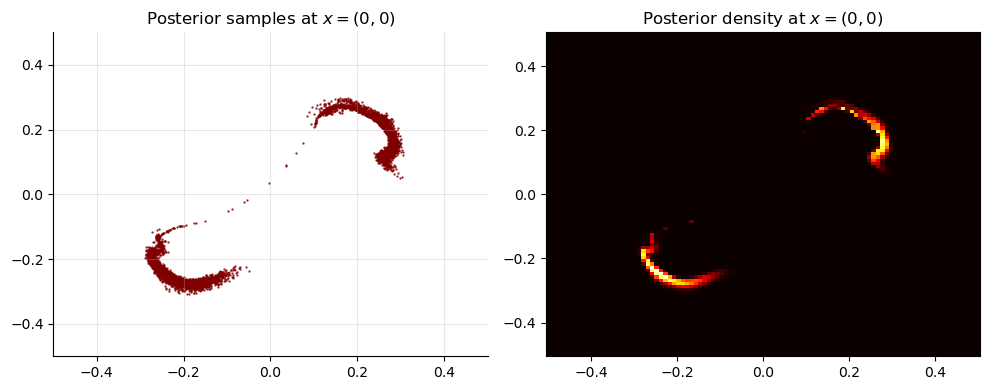

In [24]:
# Set the number of posterior draws you want to get
num_draws = 5000

# Prepare figure
f, axarr = plt.subplots(1, 2, figsize=(10, 4))

# Obtain amortized samples
obs_data = np.zeros((num_draws, 2)).astype(np.float32)
# TODO - replace with amortizer interface
samples_at_origin = inference_net.sample(num_samples=num_draws, conditions=obs_data)

# Plot samples
axarr[0].scatter(samples_at_origin[:, 0], samples_at_origin[:, 1], color="maroon", alpha=0.75, s=0.5)
sns.despine(ax=axarr[0])
axarr[0].set_title(r"Posterior samples at $x=(0, 0)$")
axarr[0].grid(alpha=0.3)
axarr[0].set_xlim([-0.5, 0.5])
axarr[0].set_ylim([-0.5, 0.5])

# Compute log density on relevant posterior range
side = np.linspace(-0.5, 0.5, 100)
x, y = np.meshgrid(side, side)
obs_data_rep = np.zeros((10000, 2)).astype(np.float32)
params = np.c_[x.flatten(), y.flatten()]
# TODO - replace with amortizer interface
lpdf = inference_net.log_prob(params, obs_data_rep)

# # Plot the density map using nearest-neighbor interpolation
axarr[1].pcolormesh(x, y, np.exp(lpdf).reshape(100, 100), cmap=cm.hot)
axarr[1].set_title(r"Posterior density at $x=(0, 0)$")

f.tight_layout()

## Further Experimentation <a class="anchor" id="further_experimentation"></a>

# TODO